# scHOT consistency analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import matplotlib as mpl
import scipy.stats as stats


In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
def concordance(x, y, log=False):
    nonnan = np.isfinite(x) & np.isfinite(y)
    return stats.spearmanr(x[nonnan],y[nonnan])[0]
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [4]:
result_path = '/data_volume/memento/simulation/acc_fpr/csv_results/'

In [5]:
schot_full = pd.read_csv(result_path + 'scHOT_0.8_res.csv')

In [6]:
rates = [0.1, 0.2, 0.4, 0.6]

In [7]:
schot_concordances = []
for rate in rates:
    schot_sub = pd.read_csv(result_path + 'scHOT_{}_res.csv'.format(rate))
    
    print(concordance(schot_full['higherOrderStatistic'], schot_sub['higherOrderStatistic']))

    schot_concordances.append(concordance(schot_full['higherOrderStatistic'], schot_sub['higherOrderStatistic']))
    
#     plt.figure()
#     plt.scatter(np.log(schot_full['higherOrderStatistic']), np.log(schot_sub['higherOrderStatistic']))

0.8126574500768048
0.7607987711213516
0.7211674347158217
0.9096405529953915


In [8]:
schot_concordances

[0.8126574500768048,
 0.7607987711213516,
 0.7211674347158217,
 0.9096405529953915]

### Basics

In [9]:
ctrl_full = pd.read_csv(result_path + 'delta_0.8_ctrl.csv').median(axis=0)
stim_full = pd.read_csv(result_path + 'delta_0.8_stim.csv').median(axis=0)
es_full = np.log(stim_full/ctrl_full)

In [10]:
rates = [0.1, 0.2, 0.4, 0.6]

In [11]:
df_list = []
basics_concordances = []
for rate in rates:
    df = pd.DataFrame()
    ctrl_sub = pd.read_csv(result_path + 'delta_{}_ctrl.csv'.format(rate)).median(axis=0)
    stim_sub = pd.read_csv(result_path + 'delta_{}_stim.csv'.format(rate)).median(axis=0)
    es_sub = np.log(stim_sub/ctrl_sub)
    
    print(concordance(es_full, es_sub))
    df['diff'] = np.abs(es_sub-es_full)
    df['rate'] = rate
    df_list.append(df)
    basics_concordances.append(concordance(es_full, es_sub))
df = pd.concat(df_list)

0.8036804915514592
0.8909554531490013
0.9510599078341013
0.9610629800307218


### Memento

In [12]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
import scipy.sparse as sparse

In [13]:
data_path = '/data_volume/memento/simulation/acc_fpr/'

In [14]:
adata_full = sc.read(data_path + 'subsampled_0.8.h5ad')

In [15]:
adata_full.X = sparse.csr_matrix(adata_full.X.astype(float))

In [16]:
adata_full.obs['q'] = 0.15

In [17]:
memento.setup_memento(adata_full, q_column='q', trim_percent=0.1)

Version 0.0.6


In [18]:
memento.create_groups(adata_full, label_columns=['stim'])
memento.compute_1d_moments(adata_full, min_perc_group=.0)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
# memento.ht_1d_moments(
#     adata_full, 
#     formula_like='1 + stim',
#     treatment_col='stim', 
#     num_boot=500, 
#     verbose=1,
#     num_cpus=14,
#     resampling='bootstrap',
#     approx=False)

In [20]:
es_full = np.log(adata_full.uns['memento']['1d_moments']['sg^stim'][1]/adata_full.uns['memento']['1d_moments']['sg^ctrl'][1])

In [21]:
df_list = []
memento_concordances = []
for rate in rates:
    df = pd.DataFrame()
    adata_sub = sc.read(data_path + 'subsampled_{}.h5ad'.format(rate))
    adata_sub.X = sparse.csr_matrix(adata_sub.X.astype(float))
    adata_sub.obs['q'] = 0.07
    memento.setup_memento(adata_sub, q_column='q', trim_percent=0.1)
    memento.create_groups(adata_sub, label_columns=['stim'])
    memento.compute_1d_moments(adata_sub, min_perc_group=.0)
    
#     memento.ht_1d_moments(
#         adata_sub, 
#         formula_like='1 + stim',
#         treatment_col='stim', 
#         num_boot=500, 
#         verbose=1,
#         num_cpus=14,
#         resampling='bootstrap',
#         approx=False)
        
#     es_sub = memento.get_1d_ht_result(adata_sub)[['gene','dv_coef']]
    es_sub = np.log(adata_sub.uns['memento']['1d_moments']['sg^stim'][1]/adata_sub.uns['memento']['1d_moments']['sg^ctrl'][1])
#     merged = es_full.merge(es_sub, on='gene')
#     print(concordance(merged['dv_coef_x'], merged['dv_coef_y']))
    print(concordance(es_full, es_sub))
    memento_concordances.append(concordance(es_full, es_sub))
    df['diff'] = np.abs(es_sub-es_full)
    df['rate'] = rate
    df_list.append(df)
    
df = pd.concat(df_list)

Version 0.0.6
0.8895924468922107
Version 0.0.6
0.9308325652841781
Version 0.0.6
0.9611182795698924
Version 0.0.6
0.9840675883256528


/tmp/ipykernel_24968/150058913.py:23: RuntimeWarning: invalid value encountered in log
  es_sub = np.log(adata_sub.uns['memento']['1d_moments']['sg^stim'][1]/adata_sub.uns['memento']['1d_moments']['sg^ctrl'][1])


Text(0.5, 1.0, 'Variability')

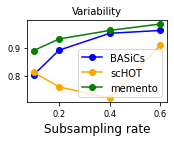

In [22]:
plt.figure(figsize=(2.5,1.5))

plt.plot(rates, basics_concordances, '-o', color='blue')
plt.plot(rates, schot_concordances, '-o', color='orange')
plt.plot(rates, memento_concordances, '-o', color='green')
plt.legend(['BASiCs', 'scHOT','memento', ])
# plt.ylabel('Concordance to\nfull data')
plt.xlabel('Subsampling rate')
plt.savefig('method_concordance.png', bbox_inches='tight', dpi=300)
plt.title('Variability')


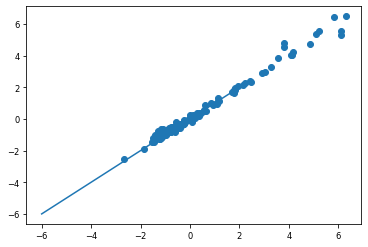

In [48]:
plt.scatter(es_sub, es_full)
plt.plot([-6,2], [-6,2])

### Correlation

In [49]:
schot_concordances = []
for rate in rates:
    schot_sub = pd.read_csv(result_path + 'scHOT_{}_res_corr.csv'.format(rate))
    
    print(concordance(schot_full['higherOrderStatistic'], schot_sub['higherOrderStatistic']))

    schot_concordances.append(concordance(schot_full['higherOrderStatistic'], schot_sub['higherOrderStatistic']))
    
#     plt.figure()
#     plt.scatter(np.log(schot_full['higherOrderStatistic']), np.log(schot_sub['higherOrderStatistic']))

0.17549923195084488
0.063892089093702
0.18980414746543778
0.12091973886328725


In [50]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
import scipy.sparse as sparse

In [51]:
data_path = '/data_volume/memento/simulation/acc_fpr/'

In [52]:
adata_full = sc.read(data_path + 'subsampled_0.8.h5ad')

In [53]:
adata_full.X = sparse.csr_matrix(adata_full.X.astype(float))

In [54]:
adata_full.obs['q'] = 0.15

In [55]:
memento.setup_memento(adata_full, q_column='q', trim_percent=0.1)

Version 0.0.6


In [56]:
memento.create_groups(adata_full, label_columns=['stim'])
memento.compute_1d_moments(adata_full, min_perc_group=.0)

In [57]:
pairs = np.array(adata_full.var.index.tolist())[:-1].reshape(-1, 2)

In [58]:
memento.compute_2d_moments(adata_full, gene_pairs=pairs)

In [59]:
es_full = adata_full.uns['memento']['2d_moments']['sg^stim']['corr']-adata_full.uns['memento']['2d_moments']['sg^ctrl']['corr']

In [60]:
df_list = []
memento_concordances = []
for rate in rates:
    df = pd.DataFrame()
    adata_sub = sc.read(data_path + 'subsampled_{}.h5ad'.format(rate))
    adata_sub.X = sparse.csr_matrix(adata_sub.X.astype(float))
    adata_sub.obs['q'] = 0.07
    memento.setup_memento(adata_sub, q_column='q', trim_percent=0.1)
    memento.create_groups(adata_sub, label_columns=['stim'])
    memento.compute_1d_moments(adata_sub, min_perc_group=.0)
    memento.compute_2d_moments(adata_sub, gene_pairs=pairs)
    
#     memento.ht_1d_moments(
#         adata_sub, 
#         formula_like='1 + stim',
#         treatment_col='stim', 
#         num_boot=500, 
#         verbose=1,
#         num_cpus=14,
#         resampling='bootstrap',
#         approx=False)
        
#     es_sub = memento.get_1d_ht_result(adata_sub)[['gene','dv_coef']]
    es_sub = adata_sub.uns['memento']['2d_moments']['sg^stim']['corr']-adata_sub.uns['memento']['2d_moments']['sg^ctrl']['corr']
#     merged = es_full.merge(es_sub, on='gene')
#     print(concordance(merged['dv_coef_x'], merged['dv_coef_y']))
    print(concordance(es_full, es_sub))
    memento_concordances.append(concordance(es_full, es_sub))
    df['diff'] = np.abs(es_sub-es_full)
    df['rate'] = rate
    df_list.append(df)
    
df = pd.concat(df_list)

Version 0.0.6
0.23900178791770546
Version 0.0.6
0.24136889023192565
Version 0.0.6
0.7126740701568834
Version 0.0.6
0.7535695399259651


Text(0.5, 1.0, 'Correlation')

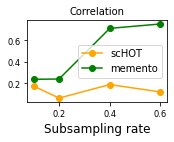

In [61]:
plt.figure(figsize=(2.5,1.5))

# plt.plot(rates, basics_concordances, '-o')
plt.plot(rates, schot_concordances, '-o', color='orange')
plt.plot(rates, memento_concordances, '-o', color='green')
plt.legend(['scHOT','memento', ])
# plt.ylabel('Concordance to\nfull data')
plt.xlabel('Subsampling rate')
plt.savefig('method_concordance_corr.png', bbox_inches='tight', dpi=300)
plt.title('Correlation')


### Mean

In [62]:
ctrl_full = pd.read_csv(result_path + 'mu_0.8_ctrl.csv').median(axis=0)
stim_full = pd.read_csv(result_path + 'mu_0.8_stim.csv').median(axis=0)
es_full = np.log(stim_full/ctrl_full)

In [63]:
rates = [0.1, 0.2, 0.4, 0.6]

In [64]:
df_list = []
basics_concordances = []
for rate in rates:
    df = pd.DataFrame()
    ctrl_sub = pd.read_csv(result_path + 'mu_{}_ctrl.csv'.format(rate)).median(axis=0)
    stim_sub = pd.read_csv(result_path + 'mu_{}_stim.csv'.format(rate)).median(axis=0)
    es_sub = np.log(stim_sub/ctrl_sub)
    
    print(concordance(es_full, es_sub))
    df['diff'] = np.abs(es_sub-es_full)
    df['rate'] = rate
    df_list.append(df)
    basics_concordances.append(concordance(es_full, es_sub))
df = pd.concat(df_list)

0.9929708141321044
0.9954224270353301
0.9984086021505373
0.9986420890937018


In [65]:
data_path = '/data_volume/memento/simulation/acc_fpr/'

In [66]:
adata_full = sc.read(data_path + 'subsampled_0.8.h5ad')

In [67]:
adata_full.X = sparse.csr_matrix(adata_full.X.astype(float))

In [68]:
adata_full.obs['q'] = 0.15

In [69]:
memento.setup_memento(adata_full, q_column='q', trim_percent=0.1)

Version 0.0.6


In [70]:
memento.create_groups(adata_full, label_columns=['stim'])
memento.compute_1d_moments(adata_full, min_perc_group=.0)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [71]:
# memento.ht_1d_moments(
#     adata_full, 
#     formula_like='1 + stim',
#     treatment_col='stim', 
#     num_boot=500, 
#     verbose=1,
#     num_cpus=14,
#     resampling='bootstrap',
#     approx=False)

In [72]:
es_full = np.log(adata_full.uns['memento']['1d_moments']['sg^stim'][0]/adata_full.uns['memento']['1d_moments']['sg^ctrl'][0])

In [73]:
df_list = []
memento_concordances = []
for rate in rates:
    df = pd.DataFrame()
    adata_sub = sc.read(data_path + 'subsampled_{}.h5ad'.format(rate))
    adata_sub.X = sparse.csr_matrix(adata_sub.X.astype(float))
    adata_sub.obs['q'] = 0.07
    memento.setup_memento(adata_sub, q_column='q', trim_percent=0.1)
    memento.create_groups(adata_sub, label_columns=['stim'])
    memento.compute_1d_moments(adata_sub, min_perc_group=.0)
    
#     memento.ht_1d_moments(
#         adata_sub, 
#         formula_like='1 + stim',
#         treatment_col='stim', 
#         num_boot=500, 
#         verbose=1,
#         num_cpus=14,
#         resampling='bootstrap',
#         approx=False)
        
#     es_sub = memento.get_1d_ht_result(adata_sub)[['gene','dv_coef']]
    es_sub = np.log(adata_sub.uns['memento']['1d_moments']['sg^stim'][0]/adata_sub.uns['memento']['1d_moments']['sg^ctrl'][0])
#     merged = es_full.merge(es_sub, on='gene')
#     print(concordance(merged['dv_coef_x'], merged['dv_coef_y']))
    print(concordance(es_full, es_sub))
    memento_concordances.append(concordance(es_full, es_sub))
    df['diff'] = np.abs(es_sub-es_full)
    df['rate'] = rate
    df_list.append(df)
    
df = pd.concat(df_list)

Version 0.0.6
0.9935791090629797
Version 0.0.6
0.996116743471582
Version 0.0.6
0.9984761904761904
Version 0.0.6
0.998943164362519


Text(0.5, 1.0, 'Mean')

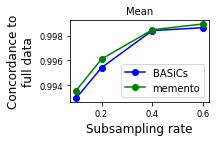

In [74]:
plt.figure(figsize=(2.5,1.5))

plt.plot(rates, basics_concordances, '-o', color='blue')
plt.plot(rates, memento_concordances, '-o', color='green')
plt.legend(['BASiCs','memento', ])
plt.ylabel('Concordance to\nfull data')
plt.xlabel('Subsampling rate')
plt.savefig('method_concordance_mean.png', bbox_inches='tight', dpi=300)
plt.title('Mean')
